In [227]:
import glob
import os.path as osp
import numpy as np
import json
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
betas = [
         0.57, 0.55, 0.53, 0.51, 0.49, 0.47, 0.45, 
         0.43, 0.41, 0.39, 0.37, 0.35, 0.33, 0.31,
        ] 
n = 500
L = 32
M = []


In [17]:
def make_path():
    target_path = osp.join("conf/isingconf_32"+"*.npy")
    print(target_path)
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [25]:
path_list = make_path()
path_list[7012]
#path_list
#sorted(path_list, key=lambda i: int(osp.splitext(osp.basename(i))[0]))

conf/isingconf_32*.npy


'conf/isingconf_32_0.45_177.npy'

In [57]:
path_list = []
labels = []
for beta in betas:
    for i in range(n):
        path_list.append(f"conf/isingconf_32_{beta}_{i}.npy")
        if beta > 0.44:
            labels.append(1)
        else:
            labels.append(0)

        
path_train = [path_list[x] for x in range(7000) if x%10!=0]
path_test = [path_list[x] for x in range(7000) if x%10==0]
labels_trian = [labels[x] for x in range(7000) if x%10!=0]
labels_test = [labels[x] for x in range(7000) if x%10==0]
len(path_test), len(path_train) , len(labels_trian) , len(labels_test)
T = np.load(path_train[2])
T=torch.tensor(T)
np.shape(T.unsqueeze(-1))

torch.Size([1024, 1])

In [207]:
class HymenopteraDataset(data.Dataset):
    
    def __init__(self, file_list,labels):
        self.file_list = file_list 
        self.labels = labels
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        #print(index)
        path = self.file_list[index]
        x = np.load(path)
        y = self.labels[index]

        x = torch.tensor(x,dtype = torch.float32)#.unsqueeze(-1)

        return x, y

In [208]:
train_dataset= HymenopteraDataset(path_train,labels_trian)
test_dataset = HymenopteraDataset(path_test,labels_test)
batch_size =500
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "test": test_dataloader}
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  
i = 0
for inputs,labels in dataloaders_dict["train"]:
    print(inputs)
    i += 1
    if i > 1:
        break

tensor([[ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1., -1.,  1.],
        [ 1.,  1.,  1.,  ..., -1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])
tensor([[-1., -1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ..., -1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1., -1.,  1.,  ..., -1., -1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])


In [214]:
class NeuralNet_ising(nn.Module):
    def __init__(self, n_input, n_out = 2):
        super(NeuralNet_ising, self).__init__()
        self.l1 = nn.Linear(n_input, 100)
        self.l2 = nn.Linear(100, n_out)
    def forward(self, x):
        #print(type(x),np.shape(x),x[0,0])
        x = torch.sigmoid(self.l1(x))
        x = self.l2(x)
        return x

In [215]:
def check_accuracy_ising(model, xs, ts):
    ys = model(xs)
    loss = nn.CrossEntropyLoss()
    output = loss(ys, ts)
    #loss = nn.softmax_cross_entropy(ys, ts)
    ys = ys.numpy()
    ys = np.argmax(ys.data, axis=1)
    cors = (ys == ts)
    num_cors = sum(cors)
    accuracy = num_cors / ts.shape[0]
    return accuracy, output

In [216]:
model = NeuralNet_ising(1024)
param=iter(model.parameters())
next(param).size()
next(param)#.size()
print(model.parameters)
inp = torch.rand(500,1024)
#loss=nn.Sigmoid()
#inp,torch.sigmoid(inp),loss(inp)
torch.sigmoid(inp).size()
#model(inp).size()
#l = [1,2,3]
#np.mean(l)

<bound method Module.parameters of NeuralNet_ising(
  (l1): Linear(in_features=1024, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=2, bias=True)
)>


torch.Size([500, 1024])

In [221]:
def training_ising(N_epochs = 3):
    model = NeuralNet_ising(1024)
    optimizer = optim.Adam(model.parameters())#, lr=LR)
    cross_entropy_loss = nn.CrossEntropyLoss()
    
    loss_history = []
    
    N_total_data = len(index_train)
    print(f"N_total_data = {N_total_data}, minibatch-size = {batch_size}" )
    for epoch in range(N_epochs) :
        loss_history_minibatch = []
        print('Epoch {}/{}'.format(epoch+1, N_epochs))
        print("---------")
        epoch_loss = 0.0
        epoch_corrects = 0
        
        for inputs,labels in tqdm(dataloaders_dict["train"]):
            optimizer.zero_grad()
            #print(inputs)
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = cross_entropy_loss(outputs, labels)
                _, preds = torch.max(outputs,1)
                #loss_history_minibatch.append(loss.item())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)  
                epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict["train"].dataset) #.dataset return the dataset of dataloader
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict["train"].dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return model

In [222]:
model = training_ising()


  0%|          | 0/13 [00:00<?, ?it/s]

N_total_data = 450, minibatch-size = 500
Epoch 1/3
---------



  8%|▊         | 1/13 [00:00<00:01,  6.33it/s]

Loss: 0.4204 Acc: 0.8208
Epoch 2/3
---------



  8%|▊         | 1/13 [00:00<00:01,  6.01it/s]

Loss: 0.2794 Acc: 0.9176
Epoch 3/3
---------



100%|██████████| 13/13 [00:02<00:00,  6.86it/s]

Loss: 0.2405 Acc: 0.9444


In [254]:
torch.max(model(conf2),0)[1].item()
1/4.4

0.22727272727272727

T= 1.75


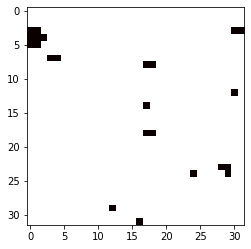

T= 1.96


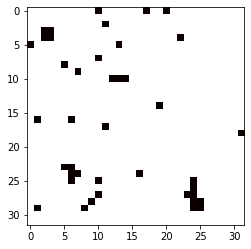

T= 2.22


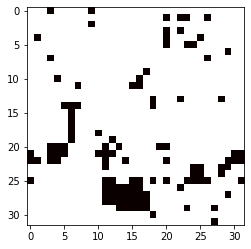

T= 2.56


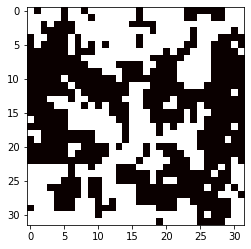

T= 3.03


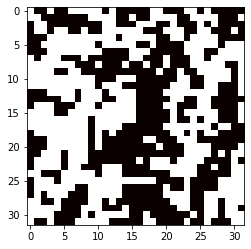

In [253]:
for i,beta in enumerate(betas):
    if i % 3 == 0:
        fname = f"conf/isingconf_32_{beta}_1.npy"
        conf1 = np.load(fname)
        print("T=",round(1/beta,2))
        plt.imshow(conf1.reshape(32,32), cmap='hot', interpolation='nearest')
        plt.show()


In [111]:
import torch
torch.manual_seed(1)

def NLLLoss(logs, targets):
    out = torch.zeros_like(targets, dtype=torch.float)
    for i in range(len(targets)):
        out[i] = logs[i][targets[i]]
    return -out.sum()/len(out)

x = torch.tensor([[-1.,  0.,  1.,  2.],[ 2.,  0.,  1., -1.]])
y = torch.LongTensor([3, 0])
cross_entropy_loss = torch.nn.CrossEntropyLoss()
log_softmax = torch.nn.LogSoftmax(dim=1)
x_log = log_softmax(x)
print(x_log,y)
nll_loss = torch.nn.NLLLoss()
print("Torch CrossEntropyLoss: ", cross_entropy_loss(x, y))
print("Torch NLL loss: ", nll_loss(x_log, y))
print("Custom NLL loss: ", NLLLoss(x_log, y))

tensor([[-3.4402, -2.4402, -1.4402, -0.4402],
        [-0.4402, -2.4402, -1.4402, -3.4402]]) tensor([3, 0])
Torch CrossEntropyLoss:  tensor(0.4402)
Torch NLL loss:  tensor(0.4402)
Custom NLL loss:  tensor(0.4402)
